Este bloco do código executa a simulação completa de uma estratégia do tipo collar, que combina ações com compra de put e venda de call para controlar risco e gerar renda. A função percorre todo o histórico de preços e reconstrói, passo a passo, como a estratégia se comportaria na prática: qual seria o custo de entrada, quando vender a call, quando rolar, quando deixar vencer e qual seria o impacto financeiro disso.

A cada operação (compra de put, venda de call, rolagens, exercício ou vencimento), o sistema registra o fluxo de caixa, o lucro ou prejuízo de cada perna e o resultado consolidado. No final, gera dois relatórios: um detalhado, mostrando cada evento do ciclo, e outro consolidado por operação, permitindo avaliar retorno, risco e eficiência da estratégia.

Em termos simples, este bloco transforma os dados de mercado em uma simulação realista de execução, permitindo testar como a estratégia funcionaria no mundo real, quantificar resultados e apoiar decisões de alocação e gestão de risco.

In [23]:

from __future__ import annotations
import math
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import norm

from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)



In [24]:
# =============================================================================
# 1) Utilitários e precificação
# =============================================================================

def bs_call(S0: float, K: float, T_days: int, r: float, sigma_annual: float) -> float:
    sigma_annual = 0.20
    if T_days <= 0 or sigma_annual <= 0:
        return max(0.0, S0 - K)
    T = T_days / 252.0
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma_annual ** 2) * T) / (sigma_annual * math.sqrt(T))
    d2 = d1 - sigma_annual * math.sqrt(T)
    return float(S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2))

def bs_put(S0: float, K: float, T_days: int, r: float, sigma_annual: float) -> float:
    sigma_annual = 0.12
    if T_days <= 0 or sigma_annual <= 0:
        return max(0.0, K - S0)
    T = T_days / 252.0
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma_annual ** 2) * T) / (sigma_annual * math.sqrt(T))
    d2 = d1 - sigma_annual * math.sqrt(T)
    return float(K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1))

def encontrar_terceiras_sextas(index: pd.DatetimeIndex) -> List[pd.Timestamp]:
    datas = pd.date_range(index.min(), index.max() + pd.Timedelta(days=370), freq='B')
    sextas = datas[datas.weekday == 4]
    terceiras: List[pd.Timestamp] = []
    for ano in range(datas.year.min(), datas.year.max() + 1):
        for mes in range(1, 13):
            s = sextas[(sextas.year == ano) & (sextas.month == mes)]
            if len(s) >= 3:
                terceiras.append(s[2])
    return sorted(set(terceiras))

def proxima_terceira_sexta(d: pd.Timestamp, terceiras: List[pd.Timestamp]) -> pd.Timestamp:
    fut = [t for t in terceiras if t >= d]
    return fut[0] if fut else d + pd.Timedelta(days=30)

def price_on_or_before(df, date):
    try:
        return float(df.loc[date, 'Close'])
    except KeyError:
        temp_df = df[df.index <= date]
        if not temp_df.empty:
            return float(temp_df.iloc[-1]['Close'])
        return np.nan



In [25]:
# =============================================================================
# 2) Estruturas de dados
# =============================================================================

@dataclass
class PositionState:
    # Classe fictícia para o código funcionar. 
    # Use a sua definição real.
    def __init__(self, cycle_id, stock_entry_date, stock_entry_px, 
                 stock_qty, put_strike, put_premium, put_expiry, 
                 put_qty, max_rolls):
        self.cycle_id = cycle_id
        self.stock_entry_date = stock_entry_date
        self.stock_entry_px = stock_entry_px
        self.stock_qty = stock_qty
        self.put_strike = put_strike
        self.put_premium = put_premium
        self.put_expiry = put_expiry
        self.put_qty = put_qty
        self.max_rolls = max_rolls
        
        self.call_strike = None
        self.call_premium = 0.0
        self.call_expiry = None
        self.call_qty = 0
        
        self.roll_count = 0
        self.rolled = False # Usado para lógica do 'miolo'
    


In [32]:
# =============================================================================
# 3) Simulação
# =============================================================================

def simulate_collar_with_qty(
    data: pd.DataFrame,
    r: float = 0.15,
    stock_qty: int = 1000,
    put_qty: int = 1000,
    call_qty: int = 1000,
    put_target_days: int = 90,
    call_otm_pct: float = 0.05,
    roll_threshold: float = 0.10,
    vol_window: int = 22,
    min_sigma_annual: float = 0.05,
    max_rolls: int = 1
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    df = data.copy()
    df = df.sort_index()
    
    rets = df['Close'].pct_change()
    sigma_annual = rets.rolling(vol_window).std() * np.sqrt(252)
    sigma_annual = sigma_annual.fillna(method='bfill').fillna(method='ffill')
    sigma_annual = sigma_annual.clip(lower=min_sigma_annual)

    terceiras = encontrar_terceiras_sextas(df.index)

    log_rows: List[Dict] = []
    cycles_rows: List[Dict] = []

    def add_log(date, cycle_id, event, S, state: Optional[PositionState], **kwargs):
        row = {
            'Date': pd.Timestamp(date),
            'CycleID': cycle_id,
            'Event': event,
            'Price': float(S),
            'StockQty': getattr(state, 'stock_qty', None),
            'PutStrike': getattr(state, 'put_strike', None),
            'PutQty': getattr(state, 'put_qty', None),
            'PutExpiry': getattr(state, 'put_expiry', None),
            'PutPremium': getattr(state, 'put_premium', None),
            'CallStrike': getattr(state, 'call_strike', None),
            'CallQty': getattr(state, 'call_qty', None),
            'CallExpiry': getattr(state, 'call_expiry', None),
            'CallPremium': getattr(state, 'call_premium', None),
        }
        row.update(kwargs)
        log_rows.append(row)

    cycle_id = 0
    i = 0
    n = len(df)

    while i < n:

        current_date = df.index[i]
        S0 = float(df.loc[current_date, 'Close'])
        sig0 = float(sigma_annual.loc[current_date])

        cycle_id += 1
        put_expiry_target = current_date + pd.Timedelta(days=put_target_days)
        put_expiry = proxima_terceira_sexta(put_expiry_target, terceiras)
        put_strike = round(S0 * 0.99 , 2)
        
        put_prem = bs_put(S0, put_strike, (put_expiry - current_date).days, r, sig0)

        state = PositionState(
            cycle_id=cycle_id,
            stock_entry_date=current_date,
            stock_entry_px=S0,
            stock_qty=stock_qty,
            put_strike=put_strike,
            put_premium=put_prem,
            put_expiry=put_expiry,
            put_qty=put_qty,
            max_rolls=max_rolls
        )
        
        add_log(current_date, cycle_id, 'PUT_BUY_STOCK_BUY', S0, state,
                StockPX=S0, Sigma=sig0, CashFlow=-(S0*stock_qty + put_prem*put_qty))

        stock_pnl = 0.0
        calls_pnl = 0.0
        put_pnl = -put_prem*put_qty

        dt = current_date
        next_idx = i
        sell_dates = [t for t in terceiras if current_date < t <= state.put_expiry]

        while next_idx < n:
            dt = df.index[next_idx]
            S = float(df.loc[dt, 'Close'])
            sig = float(sigma_annual.loc[dt])

            # --- CORREÇÃO C: Vender Call na data de entrada (ou nas datas de rolagem) ---
            if (dt == state.stock_entry_date or dt in sell_dates) and state.call_expiry is None:
                call_strike = round(S * (1 + call_otm_pct), 2)
                call_exp = proxima_terceira_sexta(dt + pd.Timedelta(days=1), terceiras)
                if call_exp > state.put_expiry:
                    call_exp = state.put_expiry
                T_days = max(0, (call_exp - dt).days)
                
                call_prem = bs_call(S, call_strike, T_days, r, sig)
                state.call_strike = call_strike
                state.call_premium = call_prem
                state.call_expiry = call_exp
                state.call_qty = call_qty
                add_log(dt, cycle_id, 'CALL_SELL', S, state,
                        Sigma=sig, CashFlow=+call_prem*call_qty)

            # Vencimento da call
            if state.call_expiry is not None and dt >= state.call_expiry:
                S_exp = price_on_or_before(df, state.call_expiry)
                intrinsic = max(S_exp - state.call_strike, 0.0)
                
                eff_call_qty = min(state.stock_qty, state.call_qty)    # Quantidade efetiva de ações cobertas
                excess_calls = max(state.call_qty - state.stock_qty, 0) # Calls extras não cobertas

                # Call virou pó
                if intrinsic <= 0:
                    calls_pnl += state.call_premium * state.call_qty
                    add_log(dt, cycle_id, 'CALL_EXPIRE_OTM', S_exp, state,
                            Intrinsic=0.0, CallPnL=state.call_premium * state.call_qty)
                    state.call_strike = None
                    state.call_premium = 0.0
                    state.call_expiry = None
                    state.call_qty = 0
                    
                # Exercício da call
                else:
                    can_roll = (state.roll_count < state.max_rolls) and (S_exp <= (1.0 + roll_threshold) * state.call_strike)
                    miolo_band = 0.02
                    in_miolo = (not state.rolled) and (abs(S_exp - state.call_strike) / state.call_strike <= miolo_band)
                    
                    
                    # Saída no miolo (Lógica mantida como solicitado)
                    if in_miolo and not can_roll:
                        # PnL considerando quantidade efetiva e excesso
                        calls_pnl += (state.call_premium - intrinsic) * eff_call_qty
                        if excess_calls > 0:
                            calls_pnl -= intrinsic * excess_calls # Prejuízo das calls extras
                        
                        # --- CORREÇÃO B (1/3): Ajuste PnL da Ação no Miolo ---
                        # (Calcula PnL das ações vendidas ao strike e das restantes ao preço de mercado)
                        stock_pnl = (S_exp - state.stock_entry_px) * (state.stock_qty - eff_call_qty) + (state.call_strike - state.stock_entry_px) * eff_call_qty
                        
                        # Put PnL
                        T_put_days = max((state.put_expiry - dt).days, 1)
                        put_val = bs_put(S_exp, state.put_strike, T_put_days, r, sig)
                        put_pnl = (put_val - state.put_premium) * state.put_qty
            
                        add_log(dt, cycle_id, 'CALL_MIOLO_EXIT', S_exp, state,
                                Intrinsic=intrinsic,
                                CallPnL=(state.call_premium - intrinsic) * eff_call_qty,
                                StockPnL=stock_pnl,
                                PutPnL=put_pnl)
            
                        cycles_rows.append({
                            'CycleID': cycle_id,
                            'StartDate': state.stock_entry_date,
                            'EndDate': dt,
                            'EntryPX': state.stock_entry_px,
                            'PutStrike': state.put_strike,
                            'PutExpiry': state.put_expiry,
                            'Rolled': state.rolled,
                            'CallsPnL': round(calls_pnl, 4),
                            'PutPnL': round(put_pnl, 4),
                            'StockPnL': round(stock_pnl, 4),
                            'TotalPnL': round(stock_pnl + calls_pnl + put_pnl, 4),
                        })
                        i = df.index.get_loc(dt) + 1
                        break
                    
                        
                    # Rolagem
                    if can_roll:
                    
                        close_cost = intrinsic * eff_call_qty
                        new_sell_date = dt
                    
                        # Itera sobre as terceiras sextas posteriores
                        vencimentos_possiveis = [t for t in terceiras if t > new_sell_date and t <= state.put_expiry]
                    
                        rolou = False
                        for new_call_exp in vencimentos_possiveis:
                            new_T = max(0, (new_call_exp - new_sell_date).days)
                            new_strike = round(S_exp * (1 + call_otm_pct), 2)
                            new_prem = bs_call(S_exp, new_strike, new_T, r, sig)
                        
                            # Testa se o prêmio novo cobre o fechamento
                            if new_prem * eff_call_qty >= close_cost:
                                
                                # --- INÍCIO DA CORREÇÃO (Brecha B: Contabilidade da Rolagem) ---
                                # (Mantida a lógica original do usuário)
                                
                                # 1. PnL da perna antiga (coberta), como na lógica original (linha 194)
                                pnl_perna_antiga_coberta = (state.call_premium * eff_call_qty) - close_cost
                                
                                # 2. PnL da perna antiga (excesso), para consistência com CALL_ASSIGNED (linha 259)
                                pnl_perna_antiga_excesso = 0.0
                                if excess_calls > 0:
                                    pnl_perna_antiga_excesso = - (intrinsic * excess_calls) # Lógica do autor (prejuízo)
                                
                                # 3. PnL total da perna que está sendo fechada
                                pnl_leg_fechada = pnl_perna_antiga_coberta + pnl_perna_antiga_excesso
                                
                                # 4. Adiciona APENAS o PnL da perna fechada à contabilidade
                                calls_pnl += pnl_leg_fechada
                                
                                # 5. Calcula o CashFlow da operação: (Prêmio Recebido Novo) - (Custo de Fechamento Total)
                                # Custo de Fechamento Total = (intrinsic * state.call_qty)
                                cash_flow_rolagem = (new_prem * state.call_qty) - (intrinsic * state.call_qty)
                                
                                add_log(dt, cycle_id, 'CALL_ROLL', S_exp, state,
                                        CloseCost=close_cost, # Custo de fechar a parte coberta (mantido da lógica original)
                                        NewStrike=new_strike,
                                        NewExpiry=new_call_exp,
                                        NewPremium=new_prem,
                                        RollPnL=pnl_leg_fechada,  # CORRIGIDO: PnL da perna fechada
                                        CashFlow=cash_flow_rolagem, # CORRIGIDO: CashFlow líquido da rolagem
                                        RollCount=state.roll_count + 1)
                                
                                # 6. Atualiza estado com os dados da NOVA opção
                                state.call_strike = new_strike
                                state.call_premium = new_prem
                                state.call_expiry = new_call_exp
                                
                                state.roll_count += 1
                                if state.roll_count >= state.max_rolls:
                                    state.rolled = True
                                
                                rolou = True
                                break  # achou um vencimento válido, sai do loop
                                
                                # --- FIM DA CORREÇÃO ---
                        
                        # Caso não tenha encontrado nenhum vencimento viável → entregar o papel
                        if not rolou:
                            calls_pnl += (state.call_premium - intrinsic) * eff_call_qty
                            if excess_calls > 0:
                                calls_pnl -= intrinsic * excess_calls
                        
                            # --- CORREÇÃO B (2/3): Ajuste PnL da Ação no Exercício (sem rolagem) ---
                            stock_pnl = (S_exp - state.stock_entry_px) * (state.stock_qty - eff_call_qty) + (state.call_strike - state.stock_entry_px) * eff_call_qty
                        
                            # Put PnL
                            T_put_days = max((state.put_expiry - dt).days, 1)
                            put_val = bs_put(S_exp, state.put_strike, T_put_days, r, sig)
                            put_pnl = (put_val - state.put_premium) * state.put_qty
                        
                            add_log(dt, cycle_id, 'CALL_ASSIGNED', S_exp, state,
                                    Intrinsic=intrinsic,
                                    CallPnL=(state.call_premium - intrinsic) * eff_call_qty,
                                    StockPnL=stock_pnl,
                                    PutPnL=put_pnl)
                        
                            cycles_rows.append({
                                'CycleID': cycle_id,
                                'StartDate': state.stock_entry_date,
                                'EndDate': dt,
                                'EntryPX': state.stock_entry_px,
                                'PutStrike': state.put_strike,
                                'PutExpiry': state.put_expiry,
                                'Rolled': state.rolled,
                                'CallsPnL': round(calls_pnl, 4),
                                'PutPnL': round(put_pnl, 4),
                                'StockPnL': round(stock_pnl, 4),
                                'TotalPnL': round(stock_pnl + calls_pnl + put_pnl, 4),
                            })
                        
                            state = None
                            i = df.index.get_loc(dt) + 1
                            break
                                
                    # Exercício (se não pode rolar e não está no miolo)
                    else:
                        calls_pnl += (state.call_premium - intrinsic) * eff_call_qty
                        if excess_calls > 0:
                            calls_pnl -= intrinsic * excess_calls

                        # --- CORREÇÃO B (3/3): Ajuste PnL da Ação no Exercício (else) ---
                        stock_pnl = (S_exp - state.stock_entry_px) * (state.stock_qty - eff_call_qty) + (state.call_strike - state.stock_entry_px) * eff_call_qty
            
                        # Put PnL
                        T_put_days = max((state.put_expiry - dt).days, 1)
                        put_val = bs_put(S_exp, state.put_strike, T_put_days, r, sig)
                        put_pnl = (put_val - state.put_premium) * state.put_qty
            
                        add_log(dt, cycle_id, 'CALL_ASSIGNED', S_exp, state,
                                Intrinsic=intrinsic,
                                CallPnL=(state.call_premium - intrinsic) * eff_call_qty,
                                StockPnL=stock_pnl,
                                PutPnL=put_pnl)
            
                        cycles_rows.append({
                            'CycleID': cycle_id,
                            'StartDate': state.stock_entry_date,
                            'EndDate': dt,
                            'EntryPX': state.stock_entry_px,
                            'PutStrike': state.put_strike,
                            'PutExpiry': state.put_expiry,
                            'Rolled': state.rolled,
                            'CallsPnL': round(calls_pnl, 4),
                            'PutPnL': round(put_pnl, 4),
                            'StockPnL': round(stock_pnl, 4),
                            'TotalPnL': round(stock_pnl + calls_pnl + put_pnl, 4),
                        })
                        state = None
                        i = df.index.get_loc(dt) + 1
                        break
            
            # Vencimento da put
            if dt >= state.put_expiry:
                S_put = price_on_or_before(df, state.put_expiry) # Preço de exerc. da put
                intrinsic_put = max(state.put_strike - S_put, 0.0) # Valor intrinsico da put
            
                eff_put_qty = min(state.put_qty, state.stock_qty) # Quantidade efetiva de puts
                excess_puts = max(state.put_qty - state.stock_qty, 0) # Puts excedentes  
            
                put_pnl += intrinsic_put * eff_put_qty
                if excess_puts > 0:
                    put_pnl += intrinsic_put * excess_puts # Lucro das puts excedentes
                    
                
                protected_stock = eff_put_qty # Quantidade de calls cobertas (na verdade, ações protegidas)
                unprotected_stock = state.stock_qty - protected_stock # Quantidade de calls descobertas (ações não protegidas)
                
                # --- CORREÇÃO A: Cálculo do PnL total da Ação no vencimento da Put ---
                # (O cálculo original zerava o PnL se 100% das ações estivessem protegidas,
                # pois multiplicava por 'unprotected_stock' que era 0)
                stock_pnl = (S_put - state.stock_entry_px) * state.stock_qty
            
                add_log(dt, cycle_id, 'PUT_EXPIRE', S_put, state,
                        IntrinsicPut=intrinsic_put,
                        ProtectedStock=protected_stock,
                        UnprotectedStock=unprotected_stock,
                        PutPnL=put_pnl,
                        StockPnL=stock_pnl)
            
                cycles_rows.append({
                    'CycleID': cycle_id,
                    'StartDate': state.stock_entry_date,
                    'EndDate': state.put_expiry,
                    'EntryPX': state.stock_entry_px,
                    'PutStrike': state.put_strike,
                    'PutExpiry': state.put_expiry,
                    'Rolled': state.rolled,
                    'CallsPnL': round(calls_pnl, 4),
                    'PutPnL': round(put_pnl, 4),
                    'StockPnL': round(stock_pnl, 4),
                    'TotalPnL': round(stock_pnl + calls_pnl + put_pnl, 4),
                })


                expiry_idx = df.index.get_loc(state.put_expiry) if state.put_expiry in df.index else df.index.searchsorted(state.put_expiry)
                i = expiry_idx + 1
                break

            next_idx += 1

        else:
            # Loop terminou sem 'break' (fim dos dados)
            last_date = df.index[-1]
            S_last = float(df.iloc[-1]['Close'])
            if state.call_expiry is not None and last_date < state.call_expiry:
                intrinsic = max(S_last - state.call_strike, 0.0)
                eff_qty = min(state.stock_qty, state.call_qty)
                calls_pnl += (state.call_premium - intrinsic)*eff_qty
                add_log(last_date, cycle_id, 'CALL_FORCED_CLOSE', S_last, state,
                        Intrinsic=intrinsic, CallPnL=(state.call_premium - intrinsic)*eff_qty)

            intrinsic_put = max(state.put_strike - S_last, 0.0)
            eff_put_qty = min(state.put_qty, state.stock_qty)
            put_pnl += intrinsic_put*eff_put_qty
            
            # --- CORREÇÃO A (Aplicada também ao 'FORCED_END') ---
            stock_pnl = (S_last - state.stock_entry_px) * state.stock_qty
            
            add_log(last_date, cycle_id, 'FORCED_END', S_last, state,
                    PutIntrinsic=intrinsic_put, StockPnL=stock_pnl, PutPnL=put_pnl)

            cycles_rows.append({
                'CycleID': cycle_id,
                'StartDate': state.stock_entry_date,
                'EndDate': last_date,
                'EntryPX': state.stock_entry_px,
                'PutStrike': state.put_strike,
                'PutExpiry': state.put_expiry,
                'Rolled': state.rolled,
                'CallsPnL': round(calls_pnl, 4),
                'PutPnL': round(put_pnl, 4),
                'StockPnL': round(stock_pnl, 4),
                'TotalPnL': round(stock_pnl + calls_pnl + put_pnl, 4),
            })

            i = n
            break

    log_trades = pd.DataFrame(log_rows).sort_values(['CycleID','Date']).reset_index(drop=True)
    cycles_summary = pd.DataFrame(cycles_rows).sort_values('CycleID').reset_index(drop=True)
    if not cycles_summary.empty:
        cycles_summary['CumPnL'] = cycles_summary['TotalPnL'].cumsum().round(4)
        cycles_summary['HoldingDays'] = (cycles_summary['EndDate'] - cycles_summary['StartDate']).dt.days

    return log_trades, cycles_summary


,Date,CycleID,Event,Price,StockQty,PutStrike,PutQty,PutExpiry,PutPremium,CallStrike,CallQty,CallExpiry,CallPremium,StockPX,Sigma,CashFlow,Intrinsic,CallPnL,IntrinsicPut,ProtectedStock,UnprotectedStock,PutPnL,StockPnL,CloseCost,NewStrike,NewExpiry,NewPremium,RollPnL,RollCount,PutIntrinsic
0,2020-10-05,1,PUT_BUY_STOCK_BUY,5.933757,1000,5.87,0,2021-01-15,0.041000,NaN,0,NaT,0.000000,5.933757,0.392621,-5933.757305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,2020-10-05,1,CALL_SELL,5.933757,1000,5.87,0,2021-01-15,0.041000,6.23,1000,2020-10-23,0.045323,NaN,0.392621,45.323492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,2020-10-23,1,CALL_EXPIRE_OTM,6.093729,1000,5.87,0,2021-01-15,0.041000,6.23,1000,2020-10-23,0.045323,NaN,NaN,NaN,0.000000,45.323492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,2020-12-18,1,CALL_SELL,8.324443,1000,5.87,0,2021-01-15,0.041000,8.74,1000,2021-01-15,0.114904,NaN,0.337577,114.903800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,2021-01-15,1,CALL_EXPIRE_OTM,8.330370,1000,5.87,0,2021-01-15,0.041000,8.74,1000,2021-01-15,0.114904,NaN,NaN,NaN,0.000000,114.903800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
5,2021-01-15,1,PUT_EXPIRE,8.330370,1000,5.87,0,2021-01-15,0.041000,NaN,0,NaT,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1000.0,0.0,2396.612644,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6,2021-01-18,2,PUT_BUY_STOCK_BUY,8.315557,1000,8.23,0,2021-05-21,0.056031,NaN,0,NaT,0.000000,8.315557,0.345305,-8315.556526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,2021-01-18,2,CALL_SELL,8.315557,1000,8.23,0,2021-05-21,0.056031,8.73,1000,2021-02-19,0.135442,NaN,0.345305,135.442157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,2021-02-19,2,CALL_EXPIRE_OTM,8.096335,1000,8.23,0,2021-05-21,0.056031,8.73,1000,2021-02-19,0.135442,NaN,NaN,NaN,0.000000,135.442157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
9,2021-03-19,2,CALL_SELL,7.109845,1000,8.23,0,2021-05-21,0.056031,7.47,1000,2021-04-16,0.096586,NaN,0.964617,96.585960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


,CycleID,StartDate,EndDate,EntryPX,PutStrike,PutExpiry,Rolled,CallsPnL,PutPnL,StockPnL,TotalPnL,CumPnL,HoldingDays
0,1,2020-10-05,2021-01-15,5.933757,5.87,2021-01-15,False,160.2273,0.0,2396.6126,2556.8399,2556.8399,102
1,2,2021-01-18,2021-05-21,8.315557,8.23,2021-05-21,False,232.0281,0.0,-369.3099,-137.2818,2419.5581,123
2,3,2021-05-24,2021-09-17,8.080985,8.00,2021-09-17,True,211.9529,0.0,7.6008,219.5537,2639.1118,116
3,4,2021-09-20,2021-10-15,7.997740,7.92,2022-01-21,False,-1109.0316,-0.0,402.2602,-706.7714,1932.3404,25
4,5,2021-10-18,2022-01-21,9.555109,9.46,2022-01-21,False,-140.9362,-0.0,1534.8910,1393.9548,3326.2952,95
5,6,2022-01-24,2022-04-18,11.645022,11.53,2022-05-20,False,-465.2476,-0.0,64.9776,-400.2700,2926.0252,84
6,7,2022-04-19,2022-08-19,12.619985,12.49,2022-08-19,True,-2472.2302,-0.0,1960.0154,-512.2148,2413.8104,122
7,8,2022-08-22,2022-12-16,17.685509,17.51,2022-12-16,False,495.2035,0.0,-4812.6669,-4317.4634,-1903.6530,116
8,9,2022-12-19,2023-01-20,13.065496,12.93,2023-04-21,False,-1463.1253,-0.0,654.5036,-808.6217,-2712.2747,32
9,10,2023-01-23,2023-04-24,15.640066,15.48,2023-05-19,False,-736.0368,-0.0,-1230.0661,-1966.1030,-4678.3777,91


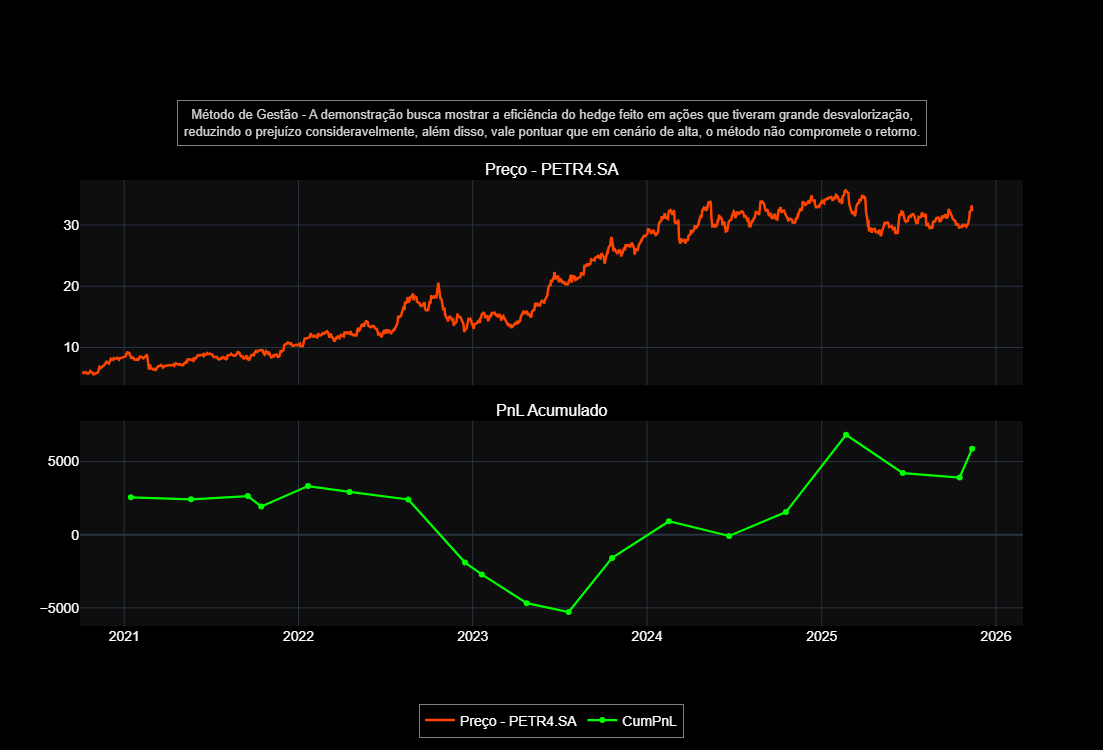

'\nCODIGO INCORRETO, QUANTO MAIS PUTS COMPRADAS MAIOR O RETORNO?\nDEVE VENDER A CALL NA MESMA DATA QUE COMPRA A PUT\nTENTAR ROLAR CALL DE FORMA POSITIVA\n\n'

In [33]:
# =============================================================================
# 4) Exemplo de uso (descomente para rodar localmente)
# =============================================================================
if __name__ == "__main__":
    # Bibliotecas
    import yfinance as yf
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Download da ação
    ticker = 'PETR4.SA'
    start = '2020-10-05'
    dados = yf.download(ticker, start=start, interval='1d', progress=False)
    
    log, resumo = simulate_collar_with_qty(
    dados,
    r=0.15,
    stock_qty=1000,   # quantidade de ações compradas
    put_qty=0,      # quantidade de puts compradas
    call_qty=1000    # quantidade de calls vendidas
)

    # Exibir cabeçalhos
    #print("LOG (amostra):")
    display(log)
    #print("\nRESUMO Por Ciclo:")
    display(resumo)
    
    # --- Corrigir o MultiIndex para uma série de preços
    precos = dados["Close"][ticker]   # ou "PETR4.SA" dependendo do ticker
    
# --- Subplots com eixo X compartilhado
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.08,
    subplot_titles=(f"Preço - {ticker}", "PnL Acumulado"))

# --- 1) Preço da ação
fig.add_trace(go.Scatter(x=precos.index,y=precos,mode="lines",name=f"Preço - {ticker}",line=dict(color="orangered", width=2.5)),row=1, col=1)

# --- 2) PnL acumulado
fig.add_trace(go.Scatter(x=resumo["EndDate"],y=resumo["CumPnL"],mode="lines+markers",name="CumPnL",line=dict(color="lime", width=2.2),
                         marker=dict(size=6, symbol="circle", color="lime")),row=2, col=1)

# --- Layout refinado estilo dark
fig.update_layout(height=750,template="plotly_dark",title_text=" ",title_x=0.5,showlegend=True,
    legend=dict(orientation="h",yanchor="bottom",y=-0.25,xanchor="center",x=0.5,bgcolor="rgba(0,0,0,0.3)",bordercolor="gray",borderwidth=1),
    plot_bgcolor="rgba(15,15,15,0.95)",paper_bgcolor="rgba(0,0,0,1)",font=dict(size=14, family="Arial", color="white"),margin=dict(t=80, b=80))

fig.add_annotation(
    text="Método de Gestão - A demonstração busca mostrar a eficiência do hedge feito em ações que tiveram grande desvalorização,<br>"
            "reduzindo o prejuízo consideravelmente, além disso, vale pontuar que em cenário de alta, o método não compromete o retorno.<br>",
    
    xref="paper", yref="paper",
    x=0.5, y=1.18,   # <- sobe um pouco mais o texto
    showarrow=False,
    font=dict(size=13, color="lightgray"),
    align="center",
    bgcolor="rgba(0,0,0,0.5)",
    bordercolor="gray",
    borderwidth=1,
    borderpad=6)

# --- Ajustar margens para dar espaço
fig.update_layout(margin=dict(t=180, b=80))

fig.show()

"""
CODIGO INCORRETO, QUANTO MAIS PUTS COMPRADAS MAIOR O RETORNO?
DEVE VENDER A CALL NA MESMA DATA QUE COMPRA A PUT
TENTAR ROLAR CALL DE FORMA POSITIVA

"""
